## Scaling Financial Time Series with Apache Spark

#### Prerequisites: 

* Use an ML Cluster with DBR version `6.0`
* Install `plotly` and `koalas=0.18.0` or later

## Business Value

One of the biggest technical challenges underlying problems in financial services is manipulating time series at scale.  Another major challenge is centralizing the wide variety of time series data sources, effectively unlocking potential value. Tick data, alternative data sets such as geospatial or transactional data, and fundamental economic data are examples of the rich data sources available to financial institutions, all of which are naturally indexed by timestamp. Solving business problems in finance such as risk, fraud, and compliance ultimately rests on being able to aggregate and analyze thousands of time series in parallel.

Below we'll show how to implement *as-of* joins for trading analysis. Then, we'll focus on data science on financial NBBO data using *Koalas* and native Python visualizations within Databricks to detect financial fraud in the form of market manipulation, particularly front running.

### 1. Merging and Scaling Analyses with Delta Lake and Apache Spark

This cell is just used to note a comment for the shell script code below, to note that in the command cell below
a shell interpreter within the Apache Spark engine is invoked (remembering that Apache Spark has different interpreters for different languages e.g. python, scala, R and the linux shell i.e. the command prompt of the underlying operating system) note that the uname command gets the name of the operating system/kernel which in this case is a linux image called 5.4.0-1072-aws, the wget command is used to get data (typically csv files) from a web location

In [0]:
%sh 

uname -r
wget https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Quotes.csv ; wget https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Trades.csv ; 

5.4.0-1088-aws
--2022-11-02 15:42:15--  https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Quotes.csv
Resolving pages.databricks.com (pages.databricks.com)... 104.17.74.206, 104.17.70.206, 104.17.71.206, ...
Connecting to pages.databricks.com (pages.databricks.com)|104.17.74.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72148443 (69M) [text/plain]
Saving to: ‘ASOF_Quotes.csv’

     0K .......... .......... .......... .......... ..........  0%  748K 94s
    50K .......... .......... .......... .......... ..........  0% 1.97M 64s
   100K .......... .......... .......... .......... ..........  0% 1.40M 59s
   150K .......... .......... .......... .......... ..........  0% 1.32M 57s
   200K .......... .......... .......... .......... ..........  0% 2.64M 51s
   250K .......... .......... .......... .......... ..........  0%  842K 56s
   300K .......... .......... .......... .......... ..........  0% 2.31M 53s
   350K .......... .......... .......... ...

In [0]:
# the fs 'filesystem' interpreter is invoked so as to run file system commands for the big data file system
# and use the 'cp' or copy command to copy the file on the local computer file system into the big data system 
# note that although the files have been now loaded into the big data file system they're still in csv format


In [0]:


%fs cp file:/databricks/driver/ASOF_Quotes.csv /tmp/finserv/ASOF_Quotes.csv


res0: Boolean = true

In [0]:
%fs cp file:/databricks/driver/ASOF_Trades.csv /tmp/finserv/ASOF_Trades.csv

res1: Boolean = true

#### 1a) Ingest Trades and Quotes (raw csv), Convert to Delta Lake

##### Why Delta Lake? 

* Delta Lake allows us to optimize formats from data providers (often large compressed flat files). This prevents value from getting locked away in silos.
* Apache Spark with Delta as our underlying performance engine gives us the scale needed to process thousands of tickers in parallel.

In [0]:
%python
from pyspark.sql.types import *
#PySpark provides from pyspark.sql.types import StructType class to define the structure of the DataFrame
#PySpark sql.types is a super class in the PySpark model that is used to define all the data types in the PySpark data model that is #used.
#StructType – Defines the structure of the Dataframe. PySpark provides from pyspark.sql.types import
# using the StructType procedure to create dataframes in Python is a bit like using the create table 
# in SQL
trade_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("trade_pr", DoubleType())
])

quote_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("bid_pr", DoubleType()),
    StructField("ask_pr", DoubleType())
])

# creating delta files - delta is a much more useful format over the traditional 'parquet' format because it is much 
# easier to do 'upserting' (i.e. both inserting and updating) using sql
# delta format is an optimised file format for processing, here the csv files are converted into Delta format
# we've pulled the csvs into the specified and defined dataframes, defined above and then we have saved those
# dataframes back to the big data file system in the delta format
# we now have a csv file and a delta file in the big data file system
# note that the delta file is a delta file as opposed to a delta data frame
spark.read.format("csv").schema(trade_schema).option("header", "true").option("delimiter", ",").load("/tmp/finserv/ASOF_Trades.csv").write.mode('overwrite').format("delta").save('/tmp/finserv/delta/trades')

spark.read.format("csv").schema(quote_schema).option("header", "true").option("delimiter", ",").load("/tmp/finserv/ASOF_Quotes.csv").write.mode('overwrite').format("delta").save('/tmp/finserv/delta/quotes')

In [0]:
display(spark.read.format("delta").load("/tmp/finserv/delta/trades"))

symbol,event_ts,trade_dt,trade_pr
EMIS,2017-08-31T11:07:15.000+0000,2017-08-31,348.3078212316816
AMH,2017-08-31T16:11:00.000+0000,2017-08-31,346.77386489787557
AMH,2017-08-31T03:30:55.000+0000,2017-08-31,347.87849677485923
CAF,2017-08-31T08:37:40.000+0000,2017-08-31,347.601070588404
AMH,2017-08-31T10:28:39.000+0000,2017-08-31,349.21094664178423
AMH,2017-08-31T17:01:41.000+0000,2017-08-31,347.7316704613105
FTS,2017-08-31T23:48:10.000+0000,2017-08-31,348.9276574655194
AMH,2017-08-31T10:08:49.000+0000,2017-08-31,347.7666476966597
AMH,2017-08-31T13:36:54.000+0000,2017-08-31,347.92480350077403
EMIS,2017-08-31T16:57:20.000+0000,2017-08-31,345.6952343728336


In [0]:
display(spark.read.format("delta").load("/tmp/finserv/delta/quotes"))

symbol,event_ts,trade_dt,bid_pr,ask_pr
ATR,2017-08-31T19:19:16.000+0000,2017-08-31,346.65996068487834,349.6215758806896
EMIS,2017-08-31T23:03:03.000+0000,2017-08-31,345.04861976770457,351.92341059306983
UBER,2017-08-31T20:19:27.000+0000,2017-08-31,346.4629124218458,350.58242216343376
EMIS,2017-08-31T22:52:25.000+0000,2017-08-31,345.29790183487074,349.73043501732064
ATR,2017-08-31T21:49:54.000+0000,2017-08-31,346.02021795626007,348.445108546719
EMIS,2017-08-31T21:18:29.000+0000,2017-08-31,347.12319899406737,351.7255773369736
ATR,2017-08-31T22:55:58.000+0000,2017-08-31,347.4956773415279,352.56502149254214
EMIS,2017-08-31T20:02:39.000+0000,2017-08-31,347.6834561985765,350.1601093709727
AMH,2017-08-31T22:39:18.000+0000,2017-08-31,348.31063058977634,351.4807102540993
EMIS,2017-08-31T21:26:49.000+0000,2017-08-31,344.48193468423005,348.4434439032349


#### 1b) Define Helper Class for As-of Joins and VWAP Aggregation

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql.window import Window

import pandas as pd

# the following class creates two functions called join and vwap, once an object is created from the class you can then pass two #datasets
# into the class and the functions will return a resultant dataset from each function as an output

class base_ts:
  
  # the constructor method definition - every class needs a constructor, this is used when an object is created from the class (the  
  # the constructor is called on creation of an object - notice that the constructor is taking a data frame object 
  # as a parameter 'df' and that means on the creation of the base_ts object you must pass a data frame as a parameter)
  # the dataframe you passed to the object is then referred to as 'self' within the object
  # notice that the keyword 'def' is used to define a function or method within the class
    def __init__(self, df):
      self.df = df
      
    # define a custom data frame join which can scale to billions of quotes - this does not need to perform a full inner join but #rather a #UNION/SORT
    
   #the function join below is unioning two datasets - strictly a union is not a join (probably the two datasets being 'unioned' are trades and the #quotes) note that one of the datasets/data frames 'self' has already been passed into the object
  # another dataframe needs to be passed into the join function when it is called and that dataframe will be referred to 
  # as 'other'
  # on creation of the object
# the join function is also  then doing the equivalent of a group by (using a windowing functioning over the symbol attribute) and using the 'last' function from
# the pyspark functions package to find the most recent offer and the most recent bid per symbol (which is why the function is used)
# Bid represents Demand-side and Bid Price highlights the price set by the buyer bid is what the buyer is trying to pay
# On the contrary, Offer represents the Supply-side - what the supplier/seller is charging for their commodity or stock
    
    def join(self, other):
        #Returns the latest right value effective at the time of the left timestamp
        #:param other: Right side of the dataset being evaluted
        #"""
        # select common fields to merge in single format
        #col is the function in pyspark which will convert column name from string type to Column type
        left = self.df.select(col('event_ts'), col('price'), col('symbol'), col('bid'), col('offer'), col('ind_cd'))
        right = other.select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd')
        # use the union function to union the two dataframes left and right
        un = left.union(right)
        
        # define partitioning keys for window - for me partitioning is like a group by where you take a column (in this case
        # symbol) and you split the values in the column into groups/windows 
        # this is actually defining a specification of a group by
        partition_spec = Window.partitionBy('symbol')
        
        # define the sort specification  - the ind_cd is the indicator of whether the record type is a trade or quote (or  
        # whatever needs to be sorted first) so the specification is stipulating to sort by timestamp and trade/quote within 
        # each window/group which has defined the partition_spec above which is invoked in this join spec
        # the following specification ahs the group by and the order in it together
        join_spec = partition_spec.orderBy('event_ts', 'ind_cd').rowsBetween(Window.unboundedPreceding, Window.currentRow)
        
        # use the 'last'' functionality to get the last bid and the last offer for each symbol
        last_val_un=un.select(col('event_ts'), col('price'), col('symbol'), col('ind_cd'), fn.last("bid", True).over(join_spec).alias("latest_bid"), fn.last("offer", True).over(join_spec).alias("latest_offer"))
        #so the function ultimately returns a data frame with the latest offer and bid for each symbol where ind_cd == 1
        return last_val_un.filter(col('ind_cd') ==1)
        
    # the function vwap takes a dataset and depending on the parameter you pass to it (m,h,d) it will take the event time series column
    # and generate a time_group column with either the minute, hour or day as a group upon which to do analysis and it will 
    # then use the timegroup column to summarise the stock by symbol by time group focussing on volume and maximum price
    # a summary/aggregate dataset is returned from calling this function and passing it a dataset
    # VWAP is a well known financial concept called Volume weighted Average Price and it is a calculation of the average 
    # price of a stock but that average is weighted according to volumes of sales per price, so for example if a high
    # volume sold at a lower price and only a small volume sold a high price - the average would reflect the high volume low
    # price
    def vwap(self, frequency='m'):
      
      # set pre_vwap as self or enrich with the frequency
      pre_vwap = self.df
      if frequency == 'm':
        # the withcolumn function is a pyspark function that can be used to create a new column within a dataframe
        # in this case we create a timegroup column which if the frequency parameter is 'm' is set to HH:MM
          pre_vwap = self.df.withColumn("time_group", concat(lpad(hour(col("event_ts")), 2, '0'), lit(':'), lpad(minute(col('event_ts')), 2, '0'))) 
      elif frequency == 'H':
          pre_vwap = self.df.withColumn("time_group", concat(lpad(hour(col("event_ts")), 2, '0')))
      elif frequency == 'D':
          pre_vwap = self.df.withColumn("time_group", concat(lpad(day(col("event_ts")), 2, '0')))
        
        # we define the pre_vwap dataset which has different properties defined after each fullstop, so first of all
        # a new column is defined called dllr_value which is price*volume grouped by hour and minute, so this is total sales
        # per minute per symbol e.g. 6 stocks in the last minute at the various prices = total sales for all 6 
        # the group by keyword is used to specify what we're grouping on for the aggregate operations
        # we use the agg keyword to specify the aggregates for the new dataframe, there are 3: sum of all sales, sum of all           #values (by minute) and max price     
      vwapped = pre_vwap.withColumn("dllr_value", col("price")*col("volume")).groupby('symbol', 'time_group').agg(sum('dllr_value').alias("dllr_value"), sum('volume').alias("volume"), max('price').alias("max_price")).withColumn("vwap", col("dllr_value")/col("volume"))
      # returns the vwapped dataframe which is basically (in the case where 'm' is the frequency), the average price
      # (weighted average) per minute for the stock
      return vwapped

In [0]:
from pyspark.sql.functions import *
# load the trades file as a dataframe in the delta format into spark memory (from the big date file system)
# but note that this time the pyspark 'withcolumn' function is being used to transform the Data Frame
# the withcolumn function can be used to: change values in a column, convert a datatype or to add a new column
# the function 'lit' is used to add a new column and so column ind_cd is added with value 1
trades = spark.read.format("delta").load("/tmp/finserv/delta/trades") \
                                   .withColumnRenamed("trade_pr", "price") \
                                   .withColumn("bid", lit(None).cast("double")) \
                                   .withColumn("offer", lit(None).cast("double")) \
                                   .withColumn("ind_cd", lit(1)) 
# can the show method be called directly in pyspark using a dataframe?
trades.show(n=10)

quotes = spark.read.format("delta").load("/tmp/finserv/delta/quotes") \
                                   .withColumn("price", lit("")) \
                                   .withColumnRenamed("bid_pr", "bid") \
                                   .withColumnRenamed("ask_pr", "offer") \
                                   .withColumn("ind_cd", lit(-1)) 
quotes.show(n=10)
# notice that the changes to the dataframe have been made as the delta files are read into spark memory
# and that at the moment those changes to the data frames only in spark memory
# the changes have not been written back to the delta files in the big data file system

+------+-------------------+----------+------------------+----+-----+------+
|symbol|           event_ts|  trade_dt|             price| bid|offer|ind_cd|
+------+-------------------+----------+------------------+----+-----+------+
|  EMIS|2017-08-31 11:07:15|2017-08-31| 348.3078212316816|null| null|     1|
|   AMH|2017-08-31 16:11:00|2017-08-31|346.77386489787557|null| null|     1|
|   AMH|2017-08-31 03:30:55|2017-08-31|347.87849677485923|null| null|     1|
|   CAF|2017-08-31 08:37:40|2017-08-31|  347.601070588404|null| null|     1|
|   AMH|2017-08-31 10:28:39|2017-08-31|349.21094664178423|null| null|     1|
|   AMH|2017-08-31 17:01:41|2017-08-31| 347.7316704613105|null| null|     1|
|   FTS|2017-08-31 23:48:10|2017-08-31| 348.9276574655194|null| null|     1|
|   AMH|2017-08-31 10:08:49|2017-08-31| 347.7666476966597|null| null|     1|
|   AMH|2017-08-31 13:36:54|2017-08-31|347.92480350077403|null| null|     1|
|  EMIS|2017-08-31 16:57:20|2017-08-31| 345.6952343728336|null| null|     1|

In [0]:
# notice that the display function shows clearly that the changes made to the delta file
# as it was read into memory have not been saved to the file system
display(spark.read.format("delta").load("/tmp/finserv/delta/trades"))

symbol,event_ts,trade_dt,trade_pr
EMIS,2017-08-31T11:07:15.000+0000,2017-08-31,348.3078212316816
AMH,2017-08-31T16:11:00.000+0000,2017-08-31,346.77386489787557
AMH,2017-08-31T03:30:55.000+0000,2017-08-31,347.87849677485923
CAF,2017-08-31T08:37:40.000+0000,2017-08-31,347.601070588404
AMH,2017-08-31T10:28:39.000+0000,2017-08-31,349.21094664178423
AMH,2017-08-31T17:01:41.000+0000,2017-08-31,347.7316704613105
FTS,2017-08-31T23:48:10.000+0000,2017-08-31,348.9276574655194
AMH,2017-08-31T10:08:49.000+0000,2017-08-31,347.7666476966597
AMH,2017-08-31T13:36:54.000+0000,2017-08-31,347.92480350077403
EMIS,2017-08-31T16:57:20.000+0000,2017-08-31,345.6952343728336


In [0]:
display(spark.read.format("delta").load("/tmp/finserv/delta/quotes"))

symbol,event_ts,trade_dt,bid_pr,ask_pr
ATR,2017-08-31T19:19:16.000+0000,2017-08-31,346.65996068487834,349.6215758806896
EMIS,2017-08-31T23:03:03.000+0000,2017-08-31,345.04861976770457,351.92341059306983
UBER,2017-08-31T20:19:27.000+0000,2017-08-31,346.4629124218458,350.58242216343376
EMIS,2017-08-31T22:52:25.000+0000,2017-08-31,345.29790183487074,349.73043501732064
ATR,2017-08-31T21:49:54.000+0000,2017-08-31,346.02021795626007,348.445108546719
EMIS,2017-08-31T21:18:29.000+0000,2017-08-31,347.12319899406737,351.7255773369736
ATR,2017-08-31T22:55:58.000+0000,2017-08-31,347.4956773415279,352.56502149254214
EMIS,2017-08-31T20:02:39.000+0000,2017-08-31,347.6834561985765,350.1601093709727
AMH,2017-08-31T22:39:18.000+0000,2017-08-31,348.31063058977634,351.4807102540993
EMIS,2017-08-31T21:26:49.000+0000,2017-08-31,344.48193468423005,348.4434439032349


#### Demonstrate Merged Format

In [0]:
# the symbol 'K' is the company kelloggs and the quotes and trades dataframes are being unioned together
# using the union function which must be a function available to Delta dataframes
un= trades.filter(col("symbol") == "K").select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd').union(quotes.filter(col("symbol") == "K").select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd'))
un.show(n=10)
display(un)

+-------------------+------------------+------+----+-----+------+
|           event_ts|             price|symbol| bid|offer|ind_cd|
+-------------------+------------------+------+----+-----+------+
|2017-08-31 03:50:20| 348.6119516556592|     K|null| null|     1|
|2017-08-31 23:29:40| 348.9429200005411|     K|null| null|     1|
|2017-08-31 21:36:07|347.38074751913484|     K|null| null|     1|
|2017-08-31 21:20:48| 349.0419269428769|     K|null| null|     1|
|2017-08-31 02:47:49|349.00659452619976|     K|null| null|     1|
|2017-08-31 00:51:16|346.91520445001134|     K|null| null|     1|
|2017-08-31 15:14:08| 346.3947630851533|     K|null| null|     1|
|2017-08-31 06:32:30| 346.7582132240916|     K|null| null|     1|
|2017-08-31 09:22:55|347.16036576622395|     K|null| null|     1|
|2017-08-31 06:56:24|349.45235333868743|     K|null| null|     1|
+-------------------+------------------+------+----+-----+------+
only showing top 10 rows



event_ts,price,symbol,bid,offer,ind_cd
2017-08-31T03:50:20.000+0000,348.6119516556592,K,null,null,1
2017-08-31T23:29:40.000+0000,348.9429200005411,K,null,null,1
2017-08-31T21:36:07.000+0000,347.38074751913484,K,null,null,1
2017-08-31T21:20:48.000+0000,349.0419269428769,K,null,null,1
2017-08-31T02:47:49.000+0000,349.00659452619976,K,null,null,1
2017-08-31T00:51:16.000+0000,346.91520445001134,K,null,null,1
2017-08-31T15:14:08.000+0000,346.3947630851533,K,null,null,1
2017-08-31T06:32:30.000+0000,346.7582132240916,K,null,null,1
2017-08-31T09:22:55.000+0000,347.16036576622395,K,null,null,1
2017-08-31T06:56:24.000+0000,349.45235333868743,K,null,null,1


#### 1c) Show Attached Bid/Offer For Each Trade

In [0]:

# create a dataframe which only contains quotes for kelloggs from the trades dataset
# for a single day, note the use of the pyspark filter function on the dataframe object trades
mkt_hrs_trades = trades.filter(col("symbol") == "K"). \
                        filter(col("event_ts") >= "2017-08-31 06:29"). \
                        filter(col("event_ts") <= "2017-08-31 16:00:00")

# invoke the base_ts class which is defined in the code above to create a base_ts object, and the constructor in the definition of # the base_ts object specifies that when the base_ts class is invoked to create a base_ts object we must pass a dataframe
# object to the constructor of that class
# as a result there is now a mkt_hrs_trades_ts object in memory from which we can call the functions (join, vwap)

mkt_hrs_trades_ts = base_ts(mkt_hrs_trades)

# define another dataframe which is all quotes (bids and offers) for Kelloggs
# notice how there is no time period specified for the quotes
quotes_ts = quotes.filter(col("symbol") == "K")

# use the join function defined in the base_ts class (instantiated as the mkt_hrs_trades_ts) to retrieve the latest bids and offers
# for each trade and notice how restricting the filter to where Ind_cd == 1 means that only the trade records are retrieved
display(mkt_hrs_trades_ts.join(quotes_ts))

event_ts,price,symbol,ind_cd,latest_bid,latest_offer
2017-08-31T06:29:58.000+0000,347.4121586706382,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:32:30.000+0000,346.7582132240916,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:37:31.000+0000,348.919146315238,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:56:24.000+0000,349.45235333868743,K,1,346.0297772384752,350.39315623662594
2017-08-31T08:38:22.000+0000,347.6687817715506,K,1,345.46234681384203,348.8679460367136
2017-08-31T08:52:59.000+0000,349.11648025163987,K,1,347.1462324487709,351.7600135730971
2017-08-31T09:22:55.000+0000,347.16036576622395,K,1,346.44863456258196,352.27114879065283
2017-08-31T10:00:54.000+0000,348.4869310969907,K,1,346.5728444681869,350.40101772579453
2017-08-31T10:52:36.000+0000,348.44707325529976,K,1,345.42173015910055,350.21440300934785
2017-08-31T12:47:15.000+0000,349.2617047407556,K,1,346.7512236007503,351.338973597199


In [0]:
display(mkt_hrs_trades_ts.join(quotes_ts))

event_ts,price,symbol,ind_cd,latest_bid,latest_offer
2017-08-31T06:29:58.000+0000,347.4121586706382,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:32:30.000+0000,346.7582132240916,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:37:31.000+0000,348.919146315238,K,1,346.0297772384752,350.39315623662594
2017-08-31T06:56:24.000+0000,349.45235333868743,K,1,346.0297772384752,350.39315623662594
2017-08-31T08:38:22.000+0000,347.6687817715506,K,1,345.46234681384203,348.8679460367136
2017-08-31T08:52:59.000+0000,349.11648025163987,K,1,347.1462324487709,351.7600135730971
2017-08-31T09:22:55.000+0000,347.16036576622395,K,1,346.44863456258196,352.27114879065283
2017-08-31T10:00:54.000+0000,348.4869310969907,K,1,346.5728444681869,350.40101772579453
2017-08-31T10:52:36.000+0000,348.44707325529976,K,1,345.42173015910055,350.21440300934785
2017-08-31T12:47:15.000+0000,349.2617047407556,K,1,346.7512236007503,351.338973597199


#### 1d) Use Pre-Defined VWAP Function to Understand Trends

In [0]:
trade_ts = base_ts(trades.select('event_ts', 'symbol', 'price', lit(100).alias("volume")))

vwap_df = trade_ts.vwap(frequency = 'm')

#vwap_df.show(10)

display(vwap_df.filter(col('symbol') == "K").filter(col('time_group').between('09:30', '16:00')).orderBy('time_group'))

symbol,time_group,dllr_value,volume,max_price,vwap
K,10:00,34848.693109699074,100,348.4869310969907,348.48693109699076
K,10:52,34844.70732552998,100,348.44707325529976,348.44707325529976
K,12:47,34926.17047407556,100,349.2617047407556,349.2617047407556
K,13:17,69636.77026098539,200,349.16422862658777,348.1838513049269
K,13:42,35035.94725526159,100,350.3594725526159,350.3594725526159
K,14:53,34593.84837375688,100,345.9384837375688,345.93848373756884
K,15:14,34639.476308515324,100,346.3947630851533,346.3947630851533


### 2. Detecting market manipulation with Koalas


<p></p>

* Note: The data obtained for the analysis below was obtained from the following source: https://www.tickdata.com/product/nbbo/

#### 2a) Download NBBO data

In [0]:
%sh wget https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/SampleEquityData_US.zip ; unzip SampleEquityData_US.zip

--2022-03-03 14:16:11--  https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/SampleEquityData_US.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.162.216
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.162.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45852068 (44M) [application/octet-stream]
Saving to: ‘SampleEquityData_US.zip’

     0K .......... .......... .......... .......... ..........  0% 24.6M 2s
    50K .......... .......... .......... .......... ..........  0% 31.6M 2s
   100K .......... .......... .......... .......... ..........  0% 14.1M 2s
   150K .......... .......... .......... .......... ..........  0% 96.8M 2s
   200K .......... .......... .......... .......... ..........  0% 72.2M 1s
   250K .......... .......... .......... .......... ..........  0%  129M 1s
   300K .......... .......... .......... .......... ..........  0% 24.3M 1s
   350K .......... .......... ..........

In [0]:
%fs cp file:/databricks/driver/NBBO/23444.csv /FileStore/tables/nbbo.csv

res0: Boolean = true

In [0]:
%python
# read  the csv file in
nbbo_df = spark.read.csv("/FileStore/tables/nbbo.csv")
nbbo_df.head(5)



Out[2]: [Row(_c0='Symbol', _c1='Date', _c2='Time', _c3='Bid Price', _c4='Bid Exchange', _c5='Bid Size', _c6='Ask Price', _c7='Ask Exchange', _c8='Ask Size'),
 Row(_c0='ITUB', _c1='03/03/2014', _c2='09:30:00.006', _c3='13.07', _c4='P', _c5='3', _c6='13.16', _c7='P', _c8='12'),
 Row(_c0='ITUB', _c1='03/03/2014', _c2='09:30:00.026', _c3='13.07', _c4='P', _c5='4', _c6='13.16', _c7='P', _c8='12'),
 Row(_c0='ITUB', _c1='03/03/2014', _c2='09:30:00.135', _c3='13.09', _c4='P', _c5='6', _c6='13.16', _c7='P', _c8='12'),
 Row(_c0='ITUB', _c1='03/03/2014', _c2='09:30:00.149', _c3='13.1', _c4='P', _c5='8', _c6='13.16', _c7='P', _c8='12')]

In [0]:
%python
# pyspark is an API, an application programming interface which in this context means a 'libary of code or programmatic objects'
# written in the python language
# and this particular api has programmatic object/code built by software engineers specifically for processing and dealing with # #big data, that means that when you invoke the pyspark api you are calling on a library of objects specifically engineered
# for dealing with big data on a big data/cloud system, in other words pyspark and the objects therein are specifically
# intended for processing big data on a cloud platform, recall that a cloud platform is a computing system on a distributed
# computing platform which means that to leverage the full power of the cloud platform/distributed computing system
# you will need to invoke code or packages specifically intended to process data on a distributed system i.e. across multiple 
# computers (nodes) instead of on a single machine

from pyspark.sql.types import *
from pyspark.sql.functions import col, concat, to_date, unix_timestamp, lit

# the StructType function is the equivalent of the SQl server 'Create table' command
# it permits you to create a dataframe in a very specific format i.e. to define very specifically the datatypes of the columns
# in your dataframe
quote_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("bid_pr", DoubleType()),
    StructField("ask_pr", DoubleType()),
    StructField("bid_shrs_qt", IntegerType()),
    StructField("ask_shrs_qt", IntegerType())
])
# create derived column using the withcolumn
# the with column statement is a bit like the 'add column' statement in sql
# create a event_ts column with the dates and times converted to a timestamp format
# drop column commands
spark.read.format("csv").option("header", "true").option("delimiter", ",").load("/FileStore/tables/nbbo.csv"). \
                         withColumn("bid_shrs_qt", 100*col("Bid Size")). \
                         withColumn("ask_shrs_qt", 100*col("Ask Size")). \
                         withColumnRenamed("Bid Price", "bid_pr"). \
                         withColumnRenamed("Ask Price", "ask_pr"). \
                         withColumn("event_ts", concat(to_date((unix_timestamp(col("Date"), 'MM/dd/yyyy')).cast("timestamp")), lit(' '), col("Time")).cast("timestamp")). \
                         drop("Bid Size"). \
                         drop("Ask Size"). \
                         drop("Bid Exchange"). \
                         drop("Ask Exchange"). \
                         write.mode('overwrite').option("mergeSchema", "true").format("delta").save('/tmp/finserv/delta/ofi_quotes2')
# note that the format changes with the various functions such as withcolumn are carried out on the file as it is read into
# the apache spark memory (as the csv file is read into memory from disk) - no changes are actually being carried out 
# on the structure of the csv file itself but rather on the dataframe in memory which is resulted from the read file operation

# notice also that once you have executed the changes on the dataframe from the csv file read, the file is then saved as a 
# Delta file, the Delta file format is a file format specifically optimised for processing data in Apache Spark on a 
# distributed cloud platform

#### 2b) Understand depth at different best bid prices

In [0]:
from pyspark.sql.functions import *

In [0]:
%python
import databricks.koalas as ks 
# koalas is another api (collection of programmatic objects), which - like pyspark - is fitted for processing data on the cloud
# for processing large volumes in a distributed computing platform, the key difference with koalas is that the packages
# and objects available in koalas for processing data look very similar to the packages and objects in the Python Pandas API
# so if you're already used to using PANDAS to process/analyse data then Koalas may be easier to use because the functions
# and objects in the Koalas API are very similar to those in the PANDAS API, note that the PANDAS API is not fitted or intended
# for processing large volumes of data on cloud platforms, that is why Python Pyspark and Koalas API were created

# of data frames in python, here we're creating a koalas data frame (table) - note that dataframe objects/table objects
# have functions and properties, so the koalas dataframe will have functions enabling you to do various things
# with that koalas dataframe e.g. filter the data using the loc function, or union the data with another dataset using the union 
# function
kdf = ks.read_delta("/tmp/finserv/delta/ofi_quotes2")
# the loc function from the koalas/pandas package can be used like a where clause to retrieve
# rows from a dataframe where a field contains a specific value
kdf_src = kdf.loc[kdf.Date == '03/05/2014']
kdf_src.head(10)

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt,event_ts
39757,ITUB,03/05/2014,09:30:00.011,13.14,13.23,700.0,200.0,2014-03-05 09:30:00.011
39758,ITUB,03/05/2014,09:30:00.052,13.15,13.23,700.0,200.0,2014-03-05 09:30:00.052
39759,ITUB,03/05/2014,09:30:00.235,13.15,13.22,700.0,100.0,2014-03-05 09:30:00.235
39760,ITUB,03/05/2014,09:30:00.236,13.16,13.22,100.0,100.0,2014-03-05 09:30:00.236
39761,ITUB,03/05/2014,09:30:00.237,13.16,13.21,100.0,700.0,2014-03-05 09:30:00.237
39762,ITUB,03/05/2014,09:30:00.956,13.16,13.21,400.0,700.0,2014-03-05 09:30:00.956
39763,ITUB,03/05/2014,09:30:01.465,13.16,13.19,400.0,1300.0,2014-03-05 09:30:01.465
39764,ITUB,03/05/2014,09:30:01.467,13.16,13.19,700.0,1300.0,2014-03-05 09:30:01.467
39765,ITUB,03/05/2014,09:30:01.476,13.16,13.22,700.0,100.0,2014-03-05 09:30:01.476
39766,ITUB,03/05/2014,09:30:01.501,13.16,13.22,400.0,100.0,2014-03-05 09:30:01.501


In [0]:
grouped_kdf = kdf_src.groupby(['event_ts'], as_index=False).max()
grouped_kdf.sort_values(by=['event_ts'])
grouped_kdf.head()

,event_ts,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt
0,2014-03-05 09:30:00.011,ITUB,03/05/2014,09:30:00.011,13.14,13.23,700.0,200.0
1,2014-03-05 09:30:00.235,ITUB,03/05/2014,09:30:00.235,13.15,13.22,700.0,100.0
2,2014-03-05 09:30:00.236,ITUB,03/05/2014,09:30:00.236,13.16,13.22,100.0,100.0
3,2014-03-05 09:30:01.476,ITUB,03/05/2014,09:30:01.476,13.16,13.22,700.0,100.0
4,2014-03-05 09:30:01.584,ITUB,03/05/2014,09:30:01.584,13.16,13.21,400.0,200.0


#### 2c) Perform windowing, merging, and aggregation with `Koalas`

In [0]:
# the indexed column event_ts is used in a join (merge) subsequently
# does adding an index optimise the processing of data in the dataframe
# on reflection i think the index is added so that when the merge operation of the two datasets is carried out below
# python 'knows' to use the index in order to effect the join, in this case the 'event_ts'
# does that mean that the Koalas/pandas merge function of the dataframe object can only work when an indexed field is cited
# or stated
grouped_kdf.set_index('event_ts', inplace=True, drop=True)
# the first period woud not actually have any values in it after the lag shift because there is no prior period to 
# fill with values from - does this avoid problems of null which potentially disrupt the join for the first record?
lag_grouped_kdf = grouped_kdf.shift(periods=1, fill_value=0)

lag_grouped_kdf.head()

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt
event_ts,,,,,,,
2014-03-05 09:30:00.011,0,0,0,0,0,0.0,0.0
2014-03-05 09:30:00.235,ITUB,03/05/2014,09:30:00.011,13.14,13.23,700.0,200.0
2014-03-05 09:30:00.236,ITUB,03/05/2014,09:30:00.235,13.15,13.22,700.0,100.0
2014-03-05 09:30:01.476,ITUB,03/05/2014,09:30:00.236,13.16,13.22,100.0,100.0
2014-03-05 09:30:01.584,ITUB,03/05/2014,09:30:01.476,13.16,13.22,700.0,100.0


In [0]:
# the merge function on the grouped_kdf dataframe is the equivalent of inner join
# notice how the join is being effected over the indexed field and that the header of the right hand fields from the table
# on the right side of the inner join are suffixed  with _lag
# also notice that the 'how' argument is missing that is to say the kind of join to  effect is not explicitly stated
# the pandas/koalas merge function permits the user to state a left join, right join or outer join as the 'how'
# but the default value for the 'how' parameter is 'inner' and so the join below is an inner join
lagged = grouped_kdf.merge(lag_grouped_kdf, left_index=True, right_index=True, suffixes=['', '_lag'])
# merge in conventional data terms as it is being applied here is an inner join
lagged.head()

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt,Symbol_lag,Date_lag,Time_lag,bid_pr_lag,ask_pr_lag,bid_shrs_qt_lag,ask_shrs_qt_lag
event_ts,,,,,,,,,,,,,,
2014-03-05 09:30:00.011,ITUB,03/05/2014,09:30:00.011,13.14,13.23,700.0,200.0,0,0,0,0,0,0.0,0.0
2014-03-05 09:30:00.235,ITUB,03/05/2014,09:30:00.235,13.15,13.22,700.0,100.0,ITUB,03/05/2014,09:30:00.011,13.14,13.23,700.0,200.0
2014-03-05 09:30:00.236,ITUB,03/05/2014,09:30:00.236,13.16,13.22,100.0,100.0,ITUB,03/05/2014,09:30:00.235,13.15,13.22,700.0,100.0
2014-03-05 09:30:01.476,ITUB,03/05/2014,09:30:01.476,13.16,13.22,700.0,100.0,ITUB,03/05/2014,09:30:00.236,13.16,13.22,100.0,100.0
2014-03-05 09:30:01.584,ITUB,03/05/2014,09:30:01.584,13.16,13.21,400.0,200.0,ITUB,03/05/2014,09:30:01.476,13.16,13.22,700.0,100.0


In [0]:
from databricks.koalas.config import set_option, reset_option
# set compute.ops_on_diff_frames option to true explicitly in  order to create a column in an existing data frame from a separate/different column/series
# i.e. a separate dataframe or series
# this reason this option is disabled by default is because this operation is resource intensive, so you can't do it by default
set_option("compute.ops_on_diff_frames", True)
from pyspark.sql.functions import *
import databricks.koalas as ks 

# this blog addresses the root of many of the errors in this section of code
#https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html

#q = lagged

# compute supply and demand from the merged data frame

#lagged['incr_demand'] = 1 if lagged.bid_pr >= lagged.bid_pr_lag else 0

# the existing syntax to the 'increased demand' column did not work, therefore i had to define a function
# to create the column (as a  series)  and then attach the series to the lagged dataframe
# this in turn necessitated the switching on of option compute.ops_on_diff_frames because that option
# is disable by default because this is regarded as an inefficient operation (see above)
# what we're doing here is simply adding a derived column

def calculateincreaseddemand(df):
    if (df['bid_pr'] >= df['bid_pr_lag']):
        return 1
    elif (df['bid_pr'] < df['bid_pr_lag']):
        return 0
      
lagged['incr_demand'] = lagged.apply(calculateincreaseddemand, axis = 1)


##lagged['decr_demand'] = 1 if lagged.bid_pr <= lagged.bid_pr_lag else 0
# define function which calulates decreased demand
def calculatedecreaseddemand(df):
    if (df['bid_pr'] <= df['bid_pr_lag']):
        return 1
    elif (df['bid_pr'] > df['bid_pr_lag']):
        return 0
#the apply method of the lagged dataframe is used to apply a function to the dataframe lagged
lagged['decr_demand'] = lagged.apply(calculatedecreaseddemand, axis = 1)

##lagged['incr_supply'] = 1 if lagged.ask_pr <= lagged.ask_pr_lag else 0
# if the the asking price in the current moment has reduced as compared to the last (or lagged) moment
# then the inference is that since the asking price has reduced then the supply of the thing in question must have increased
# hence increased supply

def calculateincreasedsupply(df):
    if (df['ask_pr'] <= df['ask_pr_lag']):
        return 1
    elif (df['ask_pr'] > df['ask_pr_lag']):
        return 0
lagged['incr_supply'] = lagged.apply(calculateincreasedsupply, axis = 1)

def calculatedecreasedsupply(df):
    if (df['ask_pr'] >= df['ask_pr_lag']):
        return 1
    elif (df['ask_pr'] < df['ask_pr_lag']):
        return 0
lagged['decr_supply'] = lagged.apply(calculatedecreasedsupply, axis = 1)

lagged[[ 'Time', 'bid_pr','bid_pr_lag','ask_pr','ask_pr_lag', 'incr_demand','decr_demand','incr_supply','decr_supply']].head()



# perform arithmetic using koalas, avoid Spark syntax

# i think a better name for the column stating 'imbalanced contributor' would be imbalanced indicator
# because the calculation generates a metric which details the imbalance in the number of shares (supply and demand)
# between one day and the next

lagged['imblnc_contrib'] = lagged['bid_shrs_qt']*lagged['incr_demand'] - lagged['bid_shrs_qt_lag']*lagged['decr_demand'] - lagged['ask_shrs_qt']*lagged['incr_supply'] + lagged['ask_shrs_qt_lag']*lagged['decr_supply']

lagged[[ 'bid_pr','bid_pr_lag', 'ask_pr','ask_pr_lag', 'bid_shrs_qt', 'ask_shrs_qt', 'bid_shrs_qt_lag', 'ask_shrs_qt_lag', 'imblnc_contrib']].head()

# note there seems to be an indicator called 'volume on the bid and ask' which simply indicates whether more buys or sells
# are happening, thus a positive number equates to stronger buys and a negative number equates to more sells - as determined
# from the volume of bids and asks and the change on price, one such indicator is termed BAVOL - volume on the bid and ask


#But i think what this 'imbalanced' is trying to show us, is whether there is a shortage of shares relative to the bids and asks
#  i mean this: if people are bidding a higher price and there are more people trying to buy than sell (at that price)
# then this indicates a shortage in stocks/shares available to buy at that price, but a fall in the asking price 
# or a higher number of asks indicates that shares are not selling and that therefore there are more shares available
# a shortage of shares should see both the asking price and bid price drive up and an increase in shares should see the
# asking price and bid price driven down - but this is supposition on my part at the moment

# intutitively, therefore, because we're discussing demand and supply (of shares) and the balance between the demand and supply
# i think that zero means that bids and asks are balanced, i think that negative volumes of shares means that demand
# is outstripping supply (that there is more demand than shares available) and i think that positive volume of shares i.e. above 0
# means that supply is outstripping demand, that is to say there are more shares available than the number people are trying to 
# buy






,bid_pr,bid_pr_lag,ask_pr,ask_pr_lag,bid_shrs_qt,ask_shrs_qt,bid_shrs_qt_lag,ask_shrs_qt_lag,imblnc_contrib
event_ts,,,,,,,,,
2014-03-05 09:30:00.011,13.14,0,13.23,0,700.0,200.0,0.0,0.0,700.0
2014-03-05 09:30:00.052,13.15,13.14,13.23,13.23,700.0,200.0,700.0,200.0,-700.0
2014-03-05 09:30:00.235,13.15,13.15,13.22,13.23,700.0,100.0,700.0,200.0,600.0
2014-03-05 09:30:00.236,13.16,13.15,13.22,13.22,100.0,100.0,700.0,100.0,100.0
2014-03-05 09:30:00.237,13.16,13.16,13.21,13.22,100.0,700.0,100.0,100.0,-600.0


#### 2d) Compute Order Flow Imbalance as a proxy for market impact

In [0]:
# the key wording in this section is 'order flow imbalance' - if you type 'order flow imbalance equation' into a search engine
# you will be met with a number of different methods of computing the imbalance of orders, that is to say large volumes posted 
# on the ask side vs lower volumes posted on the bid side (for example)
from scipy.stats import t
import scipy.stats as st
import numpy as np
# tonumpy takes the contents of the dataframe and converts it into an array (a numpy array)
# note that here we take the single column 'imblnc_contrib' from the Koalas data frame 'lagged' and convert it
# into a one dimensional numpy array
q_ofi_values = lagged['imblnc_contrib'].to_numpy()
# lets use the print function to review the contents of the numpy array called 'q_ofi_values'
# order flow imbalance (ofi) - where 0 means balanced and negative means an imbalance negatively and positive means too many # # #shares - so more people trying to sell than 
print(q_ofi_values)

[ 700.  200.  600. ... 4800.  200. -100.]


In [0]:
# scholium - lets take a deeper look at what the code is doing

# this is the content of the array of data prior to applying the '[1:] operator'
# note that with '[1:]' what we are in fact doing is what is called 'slicing' or, more specifically: 'numPY array slicing'
print ('Here is the array prior applying the [1:] slice operation to removed the first value',q_ofi_values)
print ('                                      ')
data = q_ofi_values[1:]
# we see that using the '[1:]' operator on the numpy array, removes the first value in the new  array called 'data'
# why create an exact copy of the array q_ofi_values but with the first value removed?
# why slice off a single value seemingly randomly from the data array?
print ('Here is the array  after slicing off the first value in the array using the [1:] operator :',data)
print ('                                      ')
print ('                                      ')
#create a bins variable with value 200
bins=200
# this is in preparation for creating a histogram showing frequency of order imbalance (more shares or fewer shares) - over supply 
# or under supply as related to a balance between supply and demand
# bins basically means 'columns' in histogram land
# note that the histogram function below takes two parameters, firstly the data (which is one dimensional - a set of values)
# and the second  number is a specified number of bins
# so with histograms we are into the 'how many times' territory whereby questions such as 'how many times was it this amount?' or
# 'how many times was it that amount?' can be answered, in this case where 0 indicates that there is an ask and bid balance i.e. a # balance
# between those trying to buy (bids) and those trying to sell (asks) and a negative number of shares (volume) of shares
# indicating a shortfall in availability of stocks and a positive or high number indicting an 'overabundance' of shares
# thus the more times or higher frequency of negatives we have we can say there was 'not enough shares' to go around
# and the higher the frequency of positives we can say that there 'tends to be an over abundance of shares' i.e. that there
# is a tendency for there to be more people trying to sell than those trying to buy

# notice the use of 'tends to be', i use that terminology because we're trying to spot a pattern of tendency and that is why a 
# histogram is used to answer questions of this kind; to look at the distributions and the frequency of highs and lows

# when the 'numPY' histogram function is called, the frequency of 'count' of values goes into Y and the set of unique values 
# or 'groups' goes into X, it is as if if we are doing a count of highs and lows grouping by each specific high and low value:


y, x = np.histogram(data, bins=bins)
  
# given that y now contains the frequency or count of occurrences of each value and x contains the groups or values
# X (the groups) is now adjusted using numPY roll function and also a few other operators, let us then review what 
# happens to 'X'/the groups of values depicting the order imbalances as these functions/operators are applied to these arrays
# noting that X is an array of values

print ('The first 5 elements of the X array prior to np.roll -1:',x[0:5])
print ('                                      ')
print ('The last 5 elements of the X array prior to np.roll -1:',x[len(x)-5:len(x)-0])
print ('                                      ')
print ('The first 5 elements of x ray with  np.roll -1:', np.roll(x, -1)[0:5])
print ('                                      ')
print ('The last 5 elements of x ray with  np.roll -1:', np.roll(x, -1)[len(x)-5:len(x)-0])
print ('                                      ')
# using np.roll is another way of lagging the dataset so as to apply an operation on the prior value in the series
# to the next value in the series
# i think by using roll to focus on the next value in sequence and dividing that value by 2 and then adding the resultant 
# value to the prior value in sequence we wind up with a set of values midway between the points in the series
# this process i think is called 'differencing' i.e. computing the values between a series of values
print('Applying the np.roll function and slicing off the last element in the array',np.roll(x, -1)[len(x)-5:-1])
print ('                                      ')
#now divide x array by 2 (with the last element sliced off/removed)
print ('The first 5 elements of x array lagged divided by 2',(np.roll(x, -1)[:-1] / 2.0)[0:5])
print ('                                      ')
#having divided (lagged) x values  by 2 now we now add those values back to the orginal x series
#print ('The first 5 elements of x array plus lagged x array divided by 2 (a)',(x+(np.roll(x, -1)[:-1] / 2.0)) [0:5])
print ('                                      ')
print ('The first 5 elements of x array plus lagged x array divided by 2 (b)',((x + np.roll(x, -1))[:-1] / 2.0)[0:5])

# we need to note several points about what has happened above
# firstly it looks as though the histogram function has taken the set of order imbalances values (whether over or under) and 
# sorted them into numerical order ascending from the lowest to the highest
# using the roll function the left most (and therefore lowest) imbalance value is 'rolled' to the very right of the array
# in order to now place the lowest numerical number in the array higher than the highest numerical value in the array
# why do that? this is not clear at the moment






Here is the array prior applying the [1:] slice operation to removed the first value [ 700.  200.  600. ... 4800.  200. -100.]
                                      
Here is the array  after slicing off the first value in the array using the [1:] operator : [ 200.  600.  100. ... 4800.  200. -100.]
                                      
                                      
The first 5 elements of the X array prior to np.roll -1: [-106300. -105240. -104180. -103120. -102060.]
                                      
The last 5 elements of the X array prior to np.roll -1: [101460. 102520. 103580. 104640. 105700.]
                                      
The first 5 elements of x ray with  np.roll -1: [-105240. -104180. -103120. -102060. -101000.]
                                      
The last 5 elements of x ray with  np.roll -1: [ 102520.  103580.  104640.  105700. -106300.]
                                      
Applying the np.roll function and slicing off the last element in the array

In [0]:
# next the python scipy stats class i called in order to invoke 
import scipy.stats as st
import pandas as pd

bins=200
data = q_ofi_values[1:]


# finding the best/ideal distribution to fit the series of data that we actually have
# there is actually another very similar article on this subject here:
# https://nedyoxall.github.io/fitting_all_of_scipys_distributions.html

# we define a function in python called 'best_fit_distribution' which takes 3 parameters - data (the one dimensional array of #imbalance values, bins which is the number of columns or bins in the histogram and the variable ax also which is set to none)
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data, y becomes the frequency of imbalances at a specific imbalance value
    # x becomes the range of imbalance values from negative to positive where -  indicates a negative imbalance between
    # supply and demand i.e. too little supply and too much demand and positive equals an excess supply and diminished demand
    # imbalance
    
    y, x = np.histogram(data, bins=bins)
    # note the set of all unique imbalance values 'x' is automatically ordered ascending by the numpy histogram function
    
    # in rolling the data -1 and then using the slice operator [:-1] we roll the smallest value to the end of the array and remove 
    # and this creates a 'lagged' array by effectively shifting all of the data to the left by one place
    # and by adding this 'lagged' array to the original array and dividing by 2, we create an array which has an array of #'midpoints' or points between the orginal points on the sequence of array values 
    # this is in order to find the midpoint of the 'bins' or columns
    # another reason for lagging the set/array of imbalances and then adding the unlagged series by the lagged series (such that
    # for example the first in the series is added to the second in the series) and then dividing by 2, could be in order to
    # obtain a clearer idea of the distribution - for example if we didn't take the average of the previous and subsequent values
    # within the set of values - would we really have so many zero balances?

    x = (x + np.roll(x, -1))[:-1] / 2.0

    
    # get a set of distributions from the python scipy package
    # note that the distributions are created as an array of objects in Python as denoted by  the [ ]
    # Distributions to check
    DISTRIBUTIONS = [        
        st.laplace, st.dgamma, st.powerlaw
    ]

    # Best holders
    # the default best distribution is set to be the normal distribution
    best_distribution = st.norm
    # best parameters i believe the first parameter is the mean average and the second parameter is the standard deviation
    best_params = (0.0, 1.0)
    # sse is sum of squared differences, with the difference being that between the actual for each group and the mean average
    # of the group
    # numpy infinity is used to set best_sse to be a positive infinite number like the levi-civita field which is 
    # a system of numbers containing infinite and infinitesimal quantities
    # i think a field of infinite numbers is being defined here because of a continous distribution see:
    # A continuous distribution describes the probabilities of the possible values of a continuous random variable. A continuous #random variable is a random variable with a set of possible values (known as the range) that is infinite and uncountable
    
    # inf denotes an infinite value
    best_sse = np.inf
    
    # another 'normal' distribution is created with the same parameters as the previously defined distribution
    other_distribution = st.norm
    other_params = (0.0, 1.0)
    other_sse = np.inf

    # Estimate distribution parameters from data
    
    ## use a for loop to loop through each of the three distribution objects in the distribution array
    ## this is about using scipy to 'fit' distributions to your data and when you 'fit' your data to a distribution
    ## the result from the fit will be parameters, SCIPY using a parameter estimation method called 'MLE'
    for distribution in DISTRIBUTIONS:
       
        # fit the distribution to the data 
        # this will result in a set of parameters
        params = distribution.fit(data)

        # the parameters generated from the 'fit'
        # can then be used to 'scale' the distribution to be relative to the actual series of data we have for graphical display
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1] 

        
        # the probability density function (pdf)
        # Calculate fitted PDF and error with fit in distribution
        # the pdf can be used to create a 'scaled' distribution which will be relative to the actual dataset
        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0)) # the sum of squared errors is the sum of differences between all frequancy counts
        # and the results of the probability distribution function

        # if axis pass in add to plot
        #check to see if the resultant probability distribution and actual x series of values from the histogram will graph
        # here there seems to be a missing reference to the pandas library 'pd'
        try:
            if ax:
                pd.Series(pdf, x).plot(ax=ax)
            end
        except Exception:
            'FAILURE FITTING!'

        # identify if this distribution is better
        # if best sse (the random infinite number) is higher than the sum of squared errors - it should be on the first pass of 
        # the scale! then select this distribution (as long as sum of squared errors is more than 0)
        if best_sse > sse > 0:
            best_distribution = distribution
            best_params = params
            # this is the key point in the logic - we set the best squared error to be that of the current selected distribution
            best_sse = sse

    return (best_distribution.name, best_params)

In [0]:
#create a function called make_pdf
#probability distribution function
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

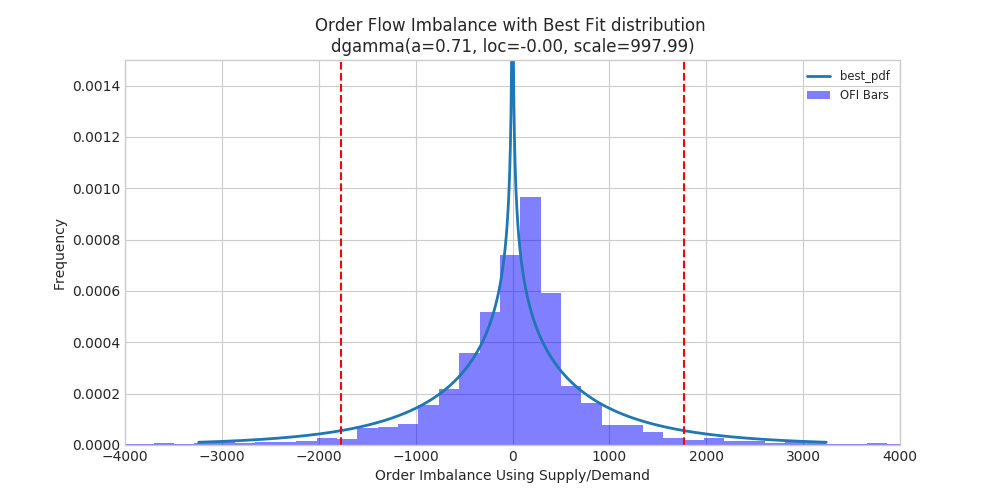

In [0]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Plot for comparison
data_flattened = pd.Series(data.flatten())

fig = plt.figure()
ax = fig.add_subplot(111)

# Load data from statsmodels datasets
data = q_ofi_values[1:]

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(10,5))
ax = pdf.plot(lw=2, label='best_pdf', legend=True)
data_flattened.plot(kind='hist', bins=1000, alpha=0.5, normed=True, label='OFI Bars', legend=True, ax=ax, color='b')
plt.legend(fontsize='small')

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Order Flow Imbalance with Best Fit distribution \n' + dist_str)
ax.set_xlabel(u'Order Imbalance Using Supply/Demand')
ax.set_ylabel('Frequency')

# define endpoints for confidence intervals for best fit distribution
lb, ub = st.dgamma.interval(alpha = 0.90, a=best_fit_params[0], loc=best_fit_params[1], scale=best_fit_params[2])

plt.axvline(x=lb, color='red', linestyle='--')
plt.axvline(x=ub, color='red', linestyle='--')

# Update plots
ax.set_xlim([-4000, 4000])
ax.set_ylim([0, 0.0015])


fig = plt.show()
display(fig)

plt.gcf().clear()

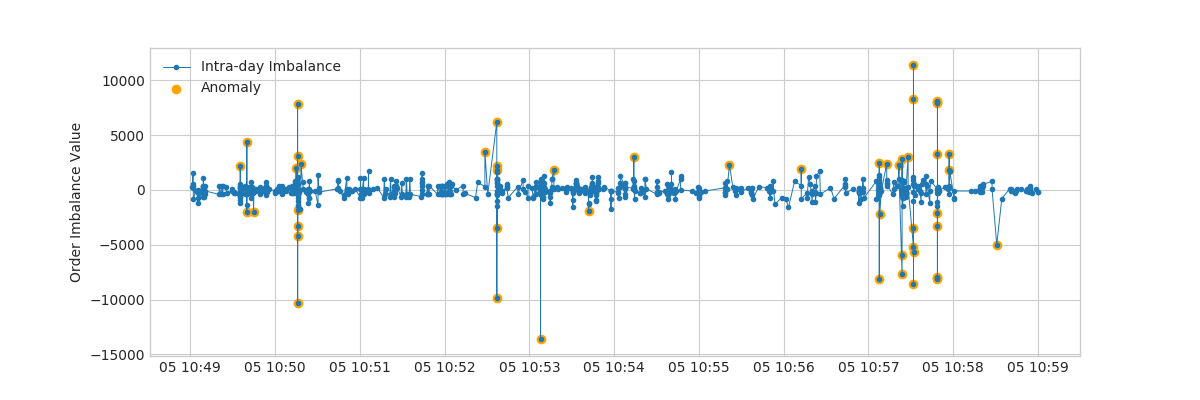

In [0]:
# Start and end of the date range to extract
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

start, end = '2014-03-05 10:49:00', '2014-03-05 10:59:00'
lagged_pdf = lagged.toPandas()[['imblnc_contrib']]
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(lagged_pdf['imblnc_contrib'][start:end], marker='o', markersize='3', linestyle='-', linewidth=0.7, label='Intra-day Imbalance')
ax.scatter(x = lagged_pdf[(lagged_pdf['imblnc_contrib'] > ub) | (lagged_pdf['imblnc_contrib'] < lb)]['imblnc_contrib'][start:end].index, y = lagged_pdf[(lagged_pdf['imblnc_contrib'] > ub) | (lagged_pdf['imblnc_contrib'] < lb)]['imblnc_contrib'][start:end], color = 'orange', label='Anomaly')

ax.set_ylabel('Order Imbalance Value')
ax.legend();

fig = plt.show()
display(fig)

plt.gcf().clear()


In [0]:
import plotly.graph_objects as go
import datetime
import numpy as np
np.random.seed(1)

programmers = ['Anomalies (10s)']

lagged_pdf['is_anmly'] = ((lagged_pdf['imblnc_contrib'] > ub) | (lagged_pdf['imblnc_contrib'] < lb))
z = lagged_pdf['is_anmly'][start:end].resample('10S').sum().values.reshape(1, 60)

base = datetime.datetime(2014, 3, 15, 10, 59, 0)
dates = base - np.arange(600) * datetime.timedelta(seconds=10)

fig = go.Figure(data=go.Heatmap(
        x=dates,
        y=programmers,
        z = z,
        colorscale='Viridis'))

fig.update_layout(
    title='1D Order Imbalance Heat Map',
    xaxis_nticks=60)

fig.show()

### Conclusion

#### 

* Koalas allowed us to easily manipulate large datasets and summarize
* Based on our Koalas feature engineering, we can then use rich statistical models in SciPy to find amomalies in our tick data
* Native Python visualizations in Databricks allow us to pinpoint time windows where we might find market manipulation and protect investors from trillion-dollar impacts